In [170]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
# https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html



%matplotlib inline

'[alt' is not recognized as an internal or external command,
operable program or batch file.



<!-- <div>
<img src="imagename.jpeg" width="300"/>
</div> -->


# Reinforcement Learning (DQN) Tutorial
**Author**: [Adam Paszke](https://github.com/apaszke)
            [Mark Towers](https://github.com/pseudo-rnd-thoughts)


This tutorial shows how to use PyTorch to train a Deep Q Learning (DQN) agent
on the CartPole-v1 task from [Gymnasium](https://gymnasium.farama.org)_.

**Task**

The agent has to decide between two actions - moving the cart left or
right - so that the pole attached to it stays upright. You can find more
information about the environment and other more challenging environments at
[Gymnasium's website](https://gymnasium.farama.org/environments/classic_control/cart_pole/)_.

.. figure:: /_static/img/cartpole.gif
   :alt: CartPole

   CartPole

As the agent observes the current state of the environment and chooses
an action, the environment *transitions* to a new state, and also
returns a reward that indicates the consequences of the action. In this
task, rewards are +1 for every incremental timestep and the environment
terminates if the pole falls over too far or the cart moves more than 2.4
units away from center. This means better performing scenarios will run
for longer duration, accumulating larger return.

The CartPole task is designed so that the inputs to the agent are 4 real
values representing the environment state (position, velocity, etc.).
We take these 4 inputs without any scaling and pass them through a 
small fully-connected network with 2 outputs, one for each action. 
The network is trained to predict the expected value for each action, 
given the input state. The action with the highest expected value is 
then chosen.


**Packages**


First, let's import needed packages. Firstly, we need
[gymnasium](https://gymnasium.farama.org/)_ for the environment,
installed by using `pip`. This is a fork of the original OpenAI
Gym project and maintained by the same team since Gym v0.19.
If you are running this in Google Colab, run:


In [2]:
!pip3 install gymnasium[classic_control]
#!pip3 install cudatoolkit
!pip3 install torch --index-url https://download.pytorch.org/whl/cu117 --upgrade --force-reinstall --trusted-host pypi.org --trusted-host pytorch.org --trusted-host download.pytorch.org
#!pip install torch>=1.5.0 cudatoolkit>=11.4.0
#!pip install torch==2.0.1+cu121
#!pip install install --index-url https://download.pytorch.org/whl/nightly/cu121/torch-2.1.0.dev20230811%2Bcu121-cp311-cp311-win_amd64.wh --trusted-host download.pytorch.org

You should consider upgrading via the 'c:\users\a493191\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


Looking in indexes: https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torch-2.0.1%2Bcu117-cp39-cp39-win_amd64.whl (2343.7 MB)
  Using cached https://download.pytorch.org/whl/typing_extensions-4.8.0-py3-none-any.whl (31 kB)
  Using cached https://download.pytorch.org/whl/filelock-3.9.0-py3-none-any.whl (9.7 kB)
  Using cached https://download.pytorch.org/whl/Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached https://download.pytorch.org/whl/sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached https://download.pytorch.org/whl/networkx-3.2.1-py3-none-any.whl (1.6 MB)
  Using cached https://download.pytorch.org/whl/MarkupSafe-2.1.3-cp39-cp39-win_amd64.whl (17 kB)
  Using cached https://download.pytorch.org/whl/mpmath-1.3.0-py3-none-any.whl (536 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.8.0
    Uninstalling typing-extensions-4.8.0:
      Successfully uninstalled typing-extensions-4.8.0
  At

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'C:\\Users\\A493191\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\~-fuser\\_C.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\users\a493191\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [1]:
#nvcc --version

import torch

print("Torch version:",torch.__version__)

print("Is CUDA enabled?",torch.cuda.is_available())

Torch version: 2.0.1+cu117
Is CUDA enabled? True


We'll also use the following from PyTorch:

-  neural networks (``torch.nn``)
-  optimization (``torch.optim``)
-  automatic differentiation (``torch.autograd``)


In [1]:
# Battery env 
import gymnasium as gym
import numpy as np
from typing import Optional, Union


class BatteryEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):

   def __init__(self, render_mode: Optional[str] = None):
      #self.zk = 9.8  # = SOC
      #self.hk = 1.0  # = hysteresis state
      #self.t = 1.0   # = temperature
      #self.vk = 1.0
      #self.rck = 1.0 # = Current through paralel resistor
      
      #...

      #self.tau = 0.01  # seconds between state updates

      self.ik = 0.1   # current


      self.vk_threshold_upper = 4.2
      self.vk_threshold_lower = 3.2

      self.soc_threshold_upper = 85
      self.soc_threshold_lower = 15


      high = np.array(
            [
            #   10,         #min= 0, max= 10       Voltage (v) - vk
               100,        #min= 0, max= 100      SOC - zk
               100,        #min= 0, max= 100      SOC - zk
            #   150,        #min= -30, max= 150    Temperature  - t
            #   1,          #min= -1, max= 1       Hysteresis state - hk
            #   100,        #min= -100, max= 100   Current through paralel resistor - rck
            #   33459,      # time 
            #   np.finfo(np.float32).max,   #min= Inf, max= Inf
         ],
         dtype=np.float32,
      )

      low = np.array(
            [
            #   0,        
               0,
               0,
            #   -30,
            #   -1,      
            #   -100,  
            #    0,       # time
            #   np.finfo(np.float32).max,
         ],
         dtype=np.float32,
      )


      # self.action_space = gym.spaces.Discrete(2)
      # self.action_space = gym.spaces.MultiDiscrete([2, 2]) #actions: charge/discharge AND cell1/cell2
      self.action_space = gym.spaces.Discrete(2) # cell1/cell2
      self.observation_space = gym.spaces.Box(low, high, dtype=np.float32)

      self.state = None
      self.steps_beyond_terminated = None
      



   def step(self, action):
      err_msg = f"{action!r} ({type(action)}) invalid"
      assert self.action_space.contains(action), err_msg
      assert self.state is not None, "Call reset before using step method."


      #vk, zk, t, hk, rck, time = self.state


      # discharge until 15, and 85 limilits

      soc0, soc1 = self.state

      # if action[0] == 1:
      #    ik = self.ik 
      # else:
      ik = -self.ik

      if action == 0:
         soc0 = soc0 + ik
      else:
         soc1 = soc1 + ik

      self.state = [soc0, soc1]

      # plot rewards within episode and SOC and actions 
      # 

      # right now the reward in only based on if the variables fall out of bounds 
      terminated = bool(
         soc0 < self.soc_threshold_lower
         or soc0 > self.soc_threshold_upper
         or soc1 < self.soc_threshold_lower
         or soc1 > self.soc_threshold_upper
         # time doesnt really make sense here for now
         #or time < 0
         #or time > 33458
      )

      if not terminated:
         # reward = 1.0 - (vk - abs(3.2))
         reward = compute_ballancing_reward(soc0, soc1, False)
      elif self.steps_beyond_terminated is None:
         # Batteries drained! Terminated.
         self.steps_beyond_terminated = 0
         # if soc0 >= 16 or soc1 >= 16:
         #    reward = -1.0
         # else:
         #    reward = 5

         reward = 0
      else:
         if self.steps_beyond_terminated == 0:
              print(
                  "You are calling 'step()' even though this "
                  "environment has already returned terminated = True. You "
                  "should always call 'reset()' once you receive 'terminated = "
                  "True' -- any further steps are undefined behavior."
               )
         self.steps_beyond_terminated += 1
         reward = 0.0


      if self.render_mode == "human":
         self.render()
      return np.array(self.state, dtype=np.float32), reward, terminated, False, {}
   

       


   def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,):
        

         super().reset(seed=seed)
         # Note that if you use custom reset bounds, it may lead to out-of-bound
         # state/observations.
         #high = utils.maybe_parse_reset_bounds(
         #    options, -0.05, 0.05  # default low
         #)  # default high

         high = np.array(
               [
               #   self.vk_threshold_upper,         #min= 0, max= 10       Voltage (v) - vk
                  85,        #min= 0, max= 100      SOC - zk
                  85,        #min= 0, max= 100      SOC - zk
               #   150,        #min= -30, max= 150    Temperature  - t
               #   1,          #min= -1, max= 1       Hysteresis state - hk
               #   100,        #min= -100, max= 100   Current through paralel resistor - rck
               #   33459,      # time 
               #   np.finfo(np.float32).max,   #min= Inf, max= Inf
            ],
            dtype=np.float32,
         )

         low = np.array(
               [
               #   self.vk_threshold_lower,        
                  15,
                  15,
               #   -30,
               #   -1,      
               #   -100,  
               #   0,       # time
               #   np.finfo(np.float32).max,
            ],
            dtype=np.float32,
         )

         #definition of an episode: 1 whole run of the matlab script
         #                               OR
         #                          1 segment of it     

         self.state = self.np_random.uniform(low=low, high=high, size=(2,))
         #initialize voltage between self.vk_threshold_upper and self.vk_threshold_lower
         #self.state[0] = 4.0

         self.steps_beyond_terminated = None

         if self.render_mode == "human":
               self.render()
         return np.array(self.state, dtype=np.float32), {}



def compute_ballancing_reward(soc0, soc1, should_print):
   reward = 0

   # mean = (soc1 + soc2)/2
   # difference1 = abs(mean - soc1)
   # difference2 = abs(mean - soc2)
   # if difference1 < 1:
   #    reward = reward + 1
   # if difference2 < 1:
   #    reward = reward + 1
   # if difference1 < 1 and difference2 < 1:
   #    reward = reward + 5
   # reward = 5 - difference1 - difference2


   reward = -pow(soc0 - soc1, 2)


   # if(should_print):
   #    print( "SOC Mean: " + str(mean) +  "    ---- SOC1 Difference    "  + str(difference1)  +  "    ----   SOC2 Difference    "  + str(difference2))
      
      
   

   return reward



In [56]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


env = BatteryEnv()


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

## Replay Memory

We'll be using experience replay memory for training our DQN. It stores
the transitions that the agent observes, allowing us to reuse this data
later. By sampling from it randomly, the transitions that build up a
batch are decorrelated. It has been shown that this greatly stabilizes
and improves the DQN training procedure.

For this, we're going to need two classes:

-  ``Transition`` - a named tuple representing a single transition in
   our environment. It essentially maps (state, action) pairs
   to their (next_state, reward) result, with the state being the
   screen difference image as described later on.
-  ``ReplayMemory`` - a cyclic buffer of bounded size that holds the
   transitions observed recently. It also implements a ``.sample()``
   method for selecting a random batch of transitions for training.




In [57]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let's quickly recap what a DQN is.

## DQN algorithm

Our environment is deterministic, so all equations presented here are
also formulated deterministically for the sake of simplicity. In the
reinforcement learning literature, they would also contain expectations
over stochastic transitions in the environment.

Our aim will be to train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is also known as the *return*. The discount,
$\gamma$, should be a constant between $0$ and $1$
that ensures the sum converges. A lower $\gamma$ makes 
rewards from the uncertain far future less important for our agent 
than the ones in the near future that it can be fairly confident 
about. It also encourages agents to collect reward closer in time 
than equivalent rewards that are temporally far away in the future.

The main idea behind Q-learning is that if we had a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell
us what our return would be, if we were to take an action in a given
state, then we could easily construct a policy that maximizes our
rewards:

\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}

However, we don't know everything about the world, so we don't have
access to $Q^*$. But, since neural networks are universal function
approximators, we can simply create one and train it to resemble
$Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}

The difference between the two sides of the equality is known as the
temporal difference error, $\delta$:

\begin{align}\delta = Q(s, a) - (r + \gamma \max_a' Q(s', a))\end{align}

To minimize this error, we will use the [Huber
loss](https://en.wikipedia.org/wiki/Huber_loss)_. The Huber loss acts
like the mean squared error when the error is small, but like the mean
absolute error when the error is large - this makes it more robust to
outliers when the estimates of $Q$ are very noisy. We calculate
this over a batch of transitions, $B$, sampled from the replay
memory:

\begin{align}\mathcal{L} = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} \mathcal{L}(\delta)\end{align}

\begin{align}\text{where} \quad \mathcal{L}(\delta) = \begin{cases}
     \frac{1}{2}{\delta^2}  & \text{for } |\delta| \le 1, \\
     |\delta| - \frac{1}{2} & \text{otherwise.}
   \end{cases}\end{align}

### Q-network

Our model will be a feed forward  neural network that takes in the
difference between the current and previous screen patches. It has two
outputs, representing $Q(s, \mathrm{left})$ and
$Q(s, \mathrm{right})$ (where $s$ is the input to the
network). In effect, the network is trying to predict the *expected return* of
taking each action given the current input.




In [58]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

## Training

### Hyperparameters and utilities
This cell instantiates our model and its optimizer, and defines some
utilities:

-  ``select_action`` - will select an action accordingly to an epsilon
   greedy policy. Simply put, we'll sometimes use our model for choosing
   the action, and sometimes we'll just sample one uniformly. The
   probability of choosing a random action will start at ``EPS_START``
   and will decay exponentially towards ``EPS_END``. ``EPS_DECAY``
   controls the rate of the decay.
-  ``plot_durations`` - a helper for plotting the duration of episodes,
   along with an average over the last 100 episodes (the measure used in
   the official evaluations). The plot will be underneath the cell
   containing the main training loop, and will update after every
   episode.




In [59]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128

#GAMMA = 0.99
GAMMA = 0.40
#EPS_START = 0.9
EPS_START = 0.9
EPS_END = 0.05
#PS_DECAY = 1000
EPS_DECAY = 1000
#TAU = 0.005
TAU = 0.005
#LR = 1e-4
LR = 1e-2


# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)



# plot_durations arrays
episode_durations = []
episode_reward_total = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    rewards_t = torch.tensor(episode_reward_total, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration and Reward')
    plt.plot(durations_t.numpy())
    plt.plot(rewards_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    if len(rewards_t) >= 100:
        means = rewards_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())



def plot_step(episode_number, state, action, reward, show_result=False):
    
    fig = plt.figure(1)

    actions_t = torch.tensor(action, dtype=torch.float)
    rewards_t = torch.tensor(reward, dtype=torch.float)

    plt.title('Episode ' + str(episode_number))
    plt.xlabel('Step')
    plt.ylabel('SOC & Actions')



    # Plot SOCs
    soc0 = []
    soc1 = []
    for st in state:
        # states_t = torch.tensor(st, dtype=torch.float)
        # plt.plot(states_t.cpu().squeeze().numpy(), label='State ' + str(st))

        soc0.append(st[0][0].item())
        soc1.append(st[0][1].item())
    
    plt.plot(soc0, label='soc0')
    plt.plot(soc1, label='soc1')



    # Plot actions as indvidual points
    action_array = np.multiply(actions_t.numpy(), 10)   # multiply action values by 10 fot better display on graph
    plt.plot(action_array, 'bo', markersize=0.4, label='Action')
    line_nr = 0

    # Plot action value as text above point
    # for line in action_array:
    #     plt.text(line_nr, line+1.8, str(int(line)), horizontalalignment='center', size='small', color='black')
    #     line_nr = line_nr + 1 


    # Plot actions as single point average
    # Take 100 steps average and plot the average action for that period
    # if len(actions_t) >= 10:
    #     means = actions_t.unfold(0, 10, 1).mean(1).view(-1)
    #     means = torch.cat((torch.zeros(9), means))
    #     plt.plot(means.numpy(), 'go', markersize=1, label='Action')

    plt.legend()



    # Plot rewards
    # Reduces displayed rewards by an order of 10 to fit within the graph
    fig2 = plt.figure(2)
    plt.title('Episode ' + str(episode_number))
    plt.xlabel('Step')
    plt.ylabel('Reward')
    plt.plot(np.divide(rewards_t.numpy(), 10), label='Reward')

    # add legend with labels
    plt.legend()




    plt.pause(0.0001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())




### Training loop

Finally, the code for training our model.

Here, you can find an ``optimize_model`` function that performs a
single step of the optimization. It first samples a batch, concatenates
all the tensors into a single one, computes $Q(s_t, a_t)$ and
$V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our
loss. By definition we set $V(s) = 0$ if $s$ is a terminal
state. We also use a target network to compute $V(s_{t+1})$ for
added stability. The target network is updated at every step with a 
[soft update](https://arxiv.org/pdf/1509.02971.pdf)_ controlled by 
the hyperparameter ``TAU``, which was previously defined.




In [60]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)

    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    


    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        #print(target_net(non_final_next_states).max(1).values)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Below, you can find the main training loop. At the beginning we reset
the environment and obtain the initial ``state`` Tensor. Then, we sample
an action, execute it, observe the next state and the reward (always
1), and optimize our model once. When the episode ends (our model
fails), we restart the loop.

Below, `num_episodes` is set to 600 if a GPU is available, otherwise 50 
episodes are scheduled so training does not take too long. However, 50 
episodes is insufficient for to observe good performance on CartPole.
You should see the model constantly achieve 500 steps within 600 training 
episodes. Training RL agents can be a noisy process, so restarting training
can produce better results if convergence is not observed.




In [61]:
import matplotlib.colors as mcolors


def begin_training(display_step_graph, display_episode_graph):
    if torch.cuda.is_available():
        num_episodes = 600
    else:
        print('cuda not available')
        num_episodes = 50

    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        state, info = env.reset()

        #while(True):
        #    print(state)

        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        last_state = None
        episode_reward = 0
        print_counter = 0

        current_episode_states = []
        current_episode_actions = []
        current_episode_rewards = []
        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            # if type(reward) == "numpy.ndarray":
            #     reward = torch.tensor(reward[0], device=device, dtype=torch.float64)
            # else:
            reward = torch.tensor([reward], device=device, dtype=torch.float64)

            
            # truncate: end episode if it lasts more than 500 steps
            if t >= 1500:
                truncated = True

            done = terminated or truncated

            if terminated:
                #print("Terminated")
                next_state = None
            else:
                next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

            # Store the transition in memory
            #print("Voltage " + str(state[0][0]) + "  ----  " + str(action) + "  ----  " + str(reward))
            # print(state)
            # print(action)
            # print(next_state)
            # print(reward)
            # print("------------------------------")
            memory.push(state, action, next_state, reward)

            # if print_counter == 3:
            #     soc1 = state[0][0] 
            #     soc2 = state[0][1]
            #     # print(soc1)
            #     # print(soc2)
            #     compute_ballancing_reward(soc1, soc2, True)
            #     print_counter = 0

            episode_reward = episode_reward + reward[0].item()
            print_counter += 1
            last_state = state


            current_episode_states.append(state)
            current_episode_actions.append(action[0].item())
            current_episode_rewards.append(reward)

            # show graph every 100 steps
            if display_step_graph and print_counter % 100 == 0:
                plot_step(len(episode_durations), current_episode_states, current_episode_actions, current_episode_rewards)


            # Move to the next state
            state = next_state


            # Perform one step of the optimization (on the policy network)
            optimize_model()

            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                episode_durations.append(t + 1)
                episode_reward_total.append(episode_reward)
                print(str(last_state) + "    " + str(reward) + "     STEPS: " + str(t))
                if display_episode_graph:
                    plot_durations()
                break


#online platform 

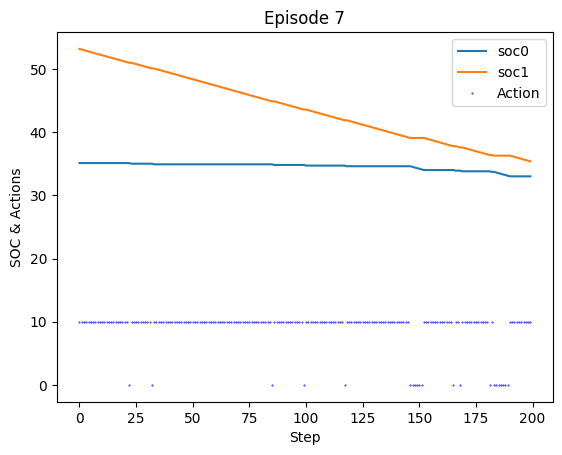

KeyboardInterrupt: 

In [62]:
# Start training!
# Traning is done on the same model every time you run this codeblock. To load a new model instead, re-run the "BATCH_SIZE" script block.

# Disable graph plots for faster training.
# Re-enable plots after some training to see how the model has evolved!
begin_training(display_step_graph=True, display_episode_graph=False)

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Here is the diagram that illustrates the overall resulting data flow.

.. figure:: /_static/img/reinforcement_learning_diagram.jpg

Actions are chosen either randomly or based on a policy, getting the next
step sample from the gym environment. We record the results in the
replay memory and also run optimization step on every iteration.
Optimization picks a random batch from the replay memory to do training of the
new policy. The "older" target_net is also used in optimization to compute the
expected Q values. A soft update of its weights are performed at every step.


